In [3]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out

In [7]:
import requests
import json

def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

In [9]:
import time
end_time = 1555700340
hrs = 24
start_time = int(end_time - 60*60*hrs)
#start_time = 1555614659
result = run_query_range(Queries["cpu"], start_time, end_time, 60)
hosts = {x[0] for x in result}
response = {}
for host in hosts:
    response[host] = [(int(x[1]), float(x[2])) for x in result if x[0]==host]

In [10]:
values = response[Nodes["k8node"]]

In [11]:
FILE_NAME = 'cpu-util.csv'
with open('cpu-util.csv', 'w') as csvfile:
    csvfile.write("TIME,UTIL\n")
    for x, y in values:
        csvfile.write(str(x) +","+str(y) + "\n")

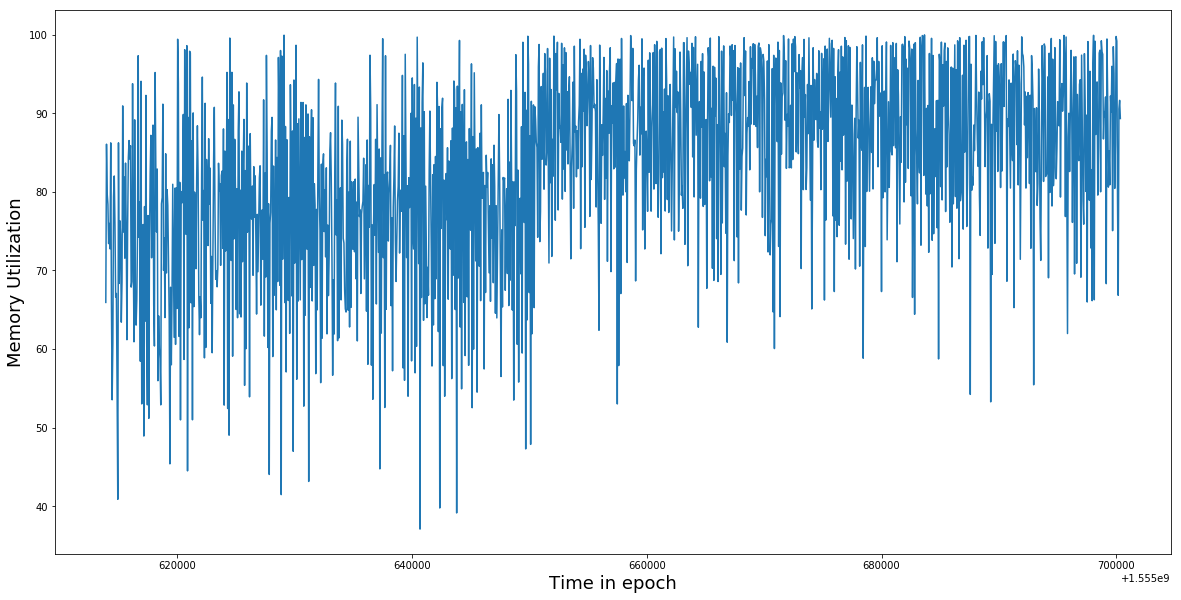

In [12]:
dataframe1 = pd.read_csv('cpu-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [13]:
split_percent = 96
train_samples = int(len(values)*split_percent/100)
values_train = values[0:train_samples]
values_test = values[train_samples:train_samples+5]

In [14]:
len(values_test)

5

In [33]:
Y_Train = [x[1] for x in values_train]
Y_Test = [x[1] for x in values_test]

# double exponential smoothing

# for i in range(1,20):
#     Y_Train = [x[1] for x in values]
#     model_fit = ExponentialSmoothing(Y_Train, seasonal_periods=i, 
#         trend='add', seasonal='add').fit(use_boxcox=True)
#     print(model_fit.aic)
# predictions = model_fit.forecast(5)

# model_arima = ARIMA(Y_Train, order=(10, 1, 0))
# model_arima_fit = model_arima.fit()
# predictions = []
# predictions = model_arima_fit.forecast(steps=10)[0]

import warnings
warnings.filterwarnings('ignore')
aicVal = []
for i in range(28, 48):
    try:
        print("i is", i)
        Y_Train = [x[1] for x in values]
        model_fit = ExponentialSmoothing(Y_Train, seasonal_periods=i, trend='add', seasonal='add').fit(use_boxcox=True)
        print(model_fit.aic)
    except:
        continue

i is 28
7157.7698189179955
i is 29
7181.6982776119485
i is 30
7195.470029842439
i is 31
7172.814106511801
i is 32
7152.908199327465
i is 33
7193.106958996656
i is 34
7169.094726783588
i is 35
7199.6672018563295
i is 36
7214.747034714264
i is 37
7162.785480849544
i is 38
7114.028421693598
i is 39
7190.688980016865
i is 40
7237.0776017691705
i is 41
7205.770725631614
i is 42
7213.148705738282
i is 43
7194.728083569103
i is 44
7261.191135005212
i is 45
7214.959169564272
i is 46
7266.17524639895
i is 47
7274.5628279394605


In [25]:
model_fit.aic

7012.864720955019

In [28]:
Y_Train = [x[1] for x in values]
model = ExponentialSmoothing(Y_Train, seasonal_periods=19, trend='add', seasonal='add').fit(use_boxcox=True)
predictions = model.forecast(5)

In [29]:
values_test

[(1555696920, 94.2901851111873),
 (1555696980, 69.13744834019028),
 (1555697040, 97.42285182231252),
 (1555697100, 88.75241973165136),
 (1555697160, 78.95140323977625)]

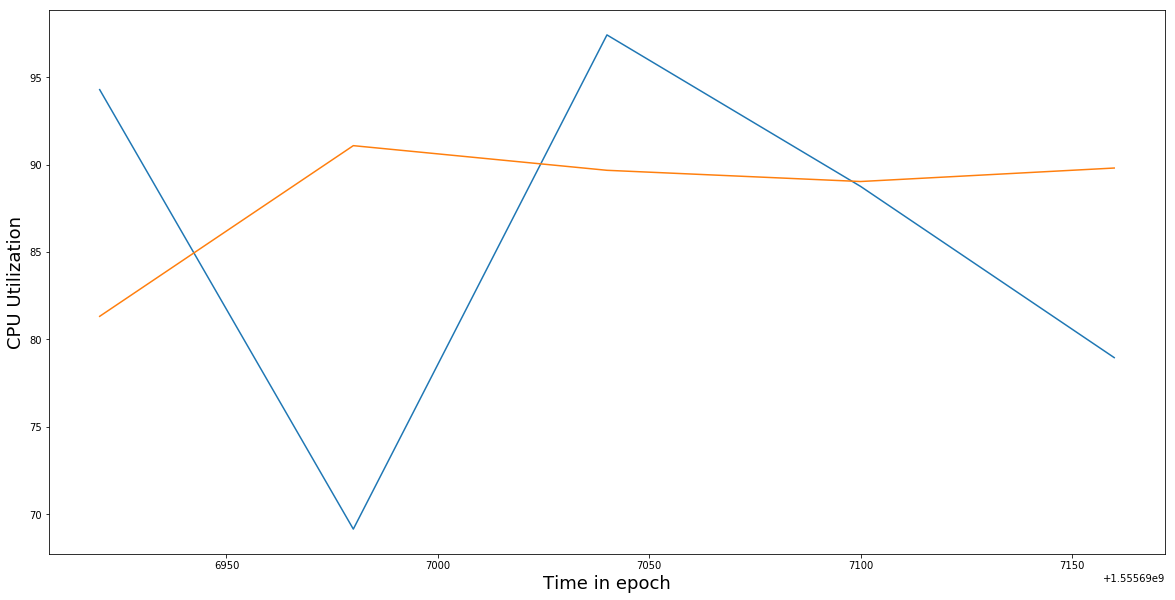

In [31]:
fig, ax = plt.subplots(1)

x1 = [x[0] for x in values_test]
y1 = [x[1] for x in values_test]

y2 = predictions

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('CPU Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})
my_plotter(ax, x1, y2, {'marker': ''})